In [24]:
# Import Required Packages
%matplotlib inline
import numpy as np
#import networkx as nx
import tqdm
import time
import random
import json
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import *

#From Qiskit library
from qiskit import *
from qiskit.visualization import *
from qiskit import IBMQ
from qiskit import BasicAer
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit import Parameter

In [37]:
#Function: Load JSON file
def loadjson( filename ):
    loaded_file = open(filename, "r")
    json_data = json.load(loaded_file)
    loaded_file.close()
    return json_data

#Function: Load Pickle file
def loadpkl( filename ):
    loaded_file = open(filename, "rb")
    pkl_data = pickle.load( loaded_file )
    loaded_file.close()
    return pkl_data

#Function: Get single term coefficients (to 4 decimal places) from Sympy Expression 
def get_coeff( variable, expression ):
    poly = Poly(expression.coeff(variable), domain = 'RR')
    return round(float(poly.coeffs()[len(poly.coeffs())-1]), 4)

#Function: Get coefficient of quadratic term (to 4 decimal places) from Sympy Expression
def quad_coeff( var_1, var_2, expression ):
    return round(float(expression.coeff(var_1).coeff(var_2)), 4)

#Binary string x of length 9, using cost/obj function from QUBO on QuadraticProgram qp.
def eval_cost(x, qp):
    return qp.objective.evaluate([int(x[no_qubits-1-i]) for i in range(no_qubits)])

#Function. Requires global variable optimal_params (list of fixed optimal paramers), 
# and global variable circuit(which is parametrized qaoa circuit to sub in parameters into), 
# and also global variable, k = current step of QAOA
# also global variable qubo = QuadraticProgram() describing the qubo
def expectation(  par  ):
    exp_val = 0
    if len(par) == 2*k:
        par2 = par
    else:
        par2 = np.insert(optimal_params, k-1, par[0])
        par2 = np.append(par2, par[1])
    circuit2 = circuit.assign_parameters({params[u] : par2[u] for u in range(len(par2))}, inplace = False)
    result = execute(circuit2, simulator).result()
    statevector = Statevector(result.get_statevector())
    prob_dict = statevector.probabilities_dict(decimals = 6)
    for state in prob_dict:
        exp_val += prob_dict[state] * eval_cost(state, qubo)
    return np.round(exp_val, 6)

In [38]:
#Read and store files into variables
car_routes = loadjson( "3cars3routes.json" )
H = loadjson( "Hamiltonian9qbits.json")
[objective, Ham, objective_normed, Ham_normed] = loadpkl("expressions.pkl")
[total_cost, constraints] = loadpkl("cost_constraints.pkl")
qubo, loaded_optimal_params = loadpkl('qubo_1.pkl')

In [31]:
loaded_optimal_params

array([-7.76614315e-01,  2.65992465e+00, -3.14159265e+00,  7.94934007e-01,
       -4.10701840e-01, -6.97573700e-16])

In [39]:
#Variables
no_routes = 3
no_cars = 3
no_qubits = no_routes * no_cars

Q = IndexedBase('Q')
car_routes_variables = {}
for route in car_routes:
    car_routes_variables[route] = Q[route[3],route[10]]
car_routes_variables

#Associate binary variable to each Q11, Q12, etc with one index for QuadraticProgram class
binary_vars = {}
for variable in car_routes_variables:
    binary_vars[car_routes_variables[variable]] = 'X' + str(no_routes*(int(variable[3])-1)+int(variable[10]))
Qvariables = tuple(binary_vars.keys())
Xvariables = tuple(binary_vars.values())
print(binary_vars)

{Q[1, 1]: 'X1', Q[1, 2]: 'X2', Q[1, 3]: 'X3', Q[2, 1]: 'X4', Q[2, 2]: 'X5', Q[2, 3]: 'X6', Q[3, 1]: 'X7', Q[3, 2]: 'X8', Q[3, 3]: 'X9'}


In [40]:
op, offset = qubo.to_ising()
print(op)

SummedOp([
  -0.8947368421052633 * IIIIIIIIZ,
  -1.0 * IIIIIIIZI,
  -0.9210526315789475 * IIIIIIZII,
  -0.7894736842105262 * IIIIIZIII,
  -0.736842105263158 * IIIIZIIII,
  -0.8947368421052633 * IIIZIIIII,
  -0.763157894736842 * IIZIIIIII,
  -0.7631578947368421 * IZIIIIIII,
  -0.736842105263158 * ZIIIIIIII,
  0.605263157894737 * IIIIIIIZZ,
  0.605263157894737 * IIIIIIZIZ,
  0.605263157894737 * IIIIIIZZI,
  0.05263157894736842 * IIIIIZIIZ,
  0.02631578947368421 * IIIIIZIZI,
  0.02631578947368421 * IIIIIZZII,
  0.02631578947368421 * IIIIZIIIZ,
  0.02631578947368421 * IIIIZIZII,
  0.5789473684210527 * IIIIZZIII,
  0.02631578947368421 * IIIZIIIIZ,
  0.10526315789473684 * IIIZIIIZI,
  0.02631578947368421 * IIIZIIZII,
  0.5789473684210527 * IIIZIZIII,
  0.5526315789473685 * IIIZZIIII,
  0.05263157894736842 * IIZIIIIIZ,
  0.02631578947368421 * IIZIIIIZI,
  0.02631578947368421 * IIZIIIZII,
  0.02631578947368421 * IIZIIZIII,
  0.02631578947368421 * IIZIZIIII,
  0.02631578947368421 * IZIIIIIZI,
 

In [41]:
optimal_pairs = [] #Pair the gamma, beta for each step
no_steps = 3
for k in range(no_steps):
    optimal_pairs.append(tuple((loaded_optimal_params[k], loaded_optimal_params[k+no_steps])) )
optimal_pairs

[(-0.7766143145178575, 0.7949340074095693),
 (2.6599246486105277, -0.41070183959133855),
 (-3.141592653589793, -6.975736996017264e-16)]

In [42]:
#optimal_params = np.array([])
#optimal_params = np.append(optimal_params, optimal_pairs[0] )
#optimal_params
optimal_pairs

[(-0.7766143145178575, 0.7949340074095693),
 (2.6599246486105277, -0.41070183959133855),
 (-3.141592653589793, -6.975736996017264e-16)]

In [43]:
optimal_params = []
simulator = StatevectorSimulator()
for k in range(1,4):
    params = []
    for _ in range(k):
        params.append( Parameter('a'+str(_+1)) )
    for _ in range(k):
        params.append( Parameter('b'+str(_+1)) )    
    qaoa = QAOA(operator = op, p=k, quantum_instance=Aer.get_backend('statevector_simulator'))
    circuit = qaoa.construct_circuit( params[0:2*k] )[0]
    exp_val = expectation( loaded_optimal_params[0:2*k] )
    print(f'step {k}: {exp_val}')
print('Done')

step 1: 5.131978
step 2: 5.180008
step 3: 0.942872
Done


In [25]:
params = []
counts = []
for k in range(1,9):
    params = np.append( params, optimal_pairs[k-1])
    qaoa = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
    circuit = qaoa.construct_circuit( params )[0]
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(circuit, simulator).result()
    statevector = Statevector(result.get_statevector())
    counts.append( statevector.sample_counts(shots = 10000) )    

KeyboardInterrupt: 

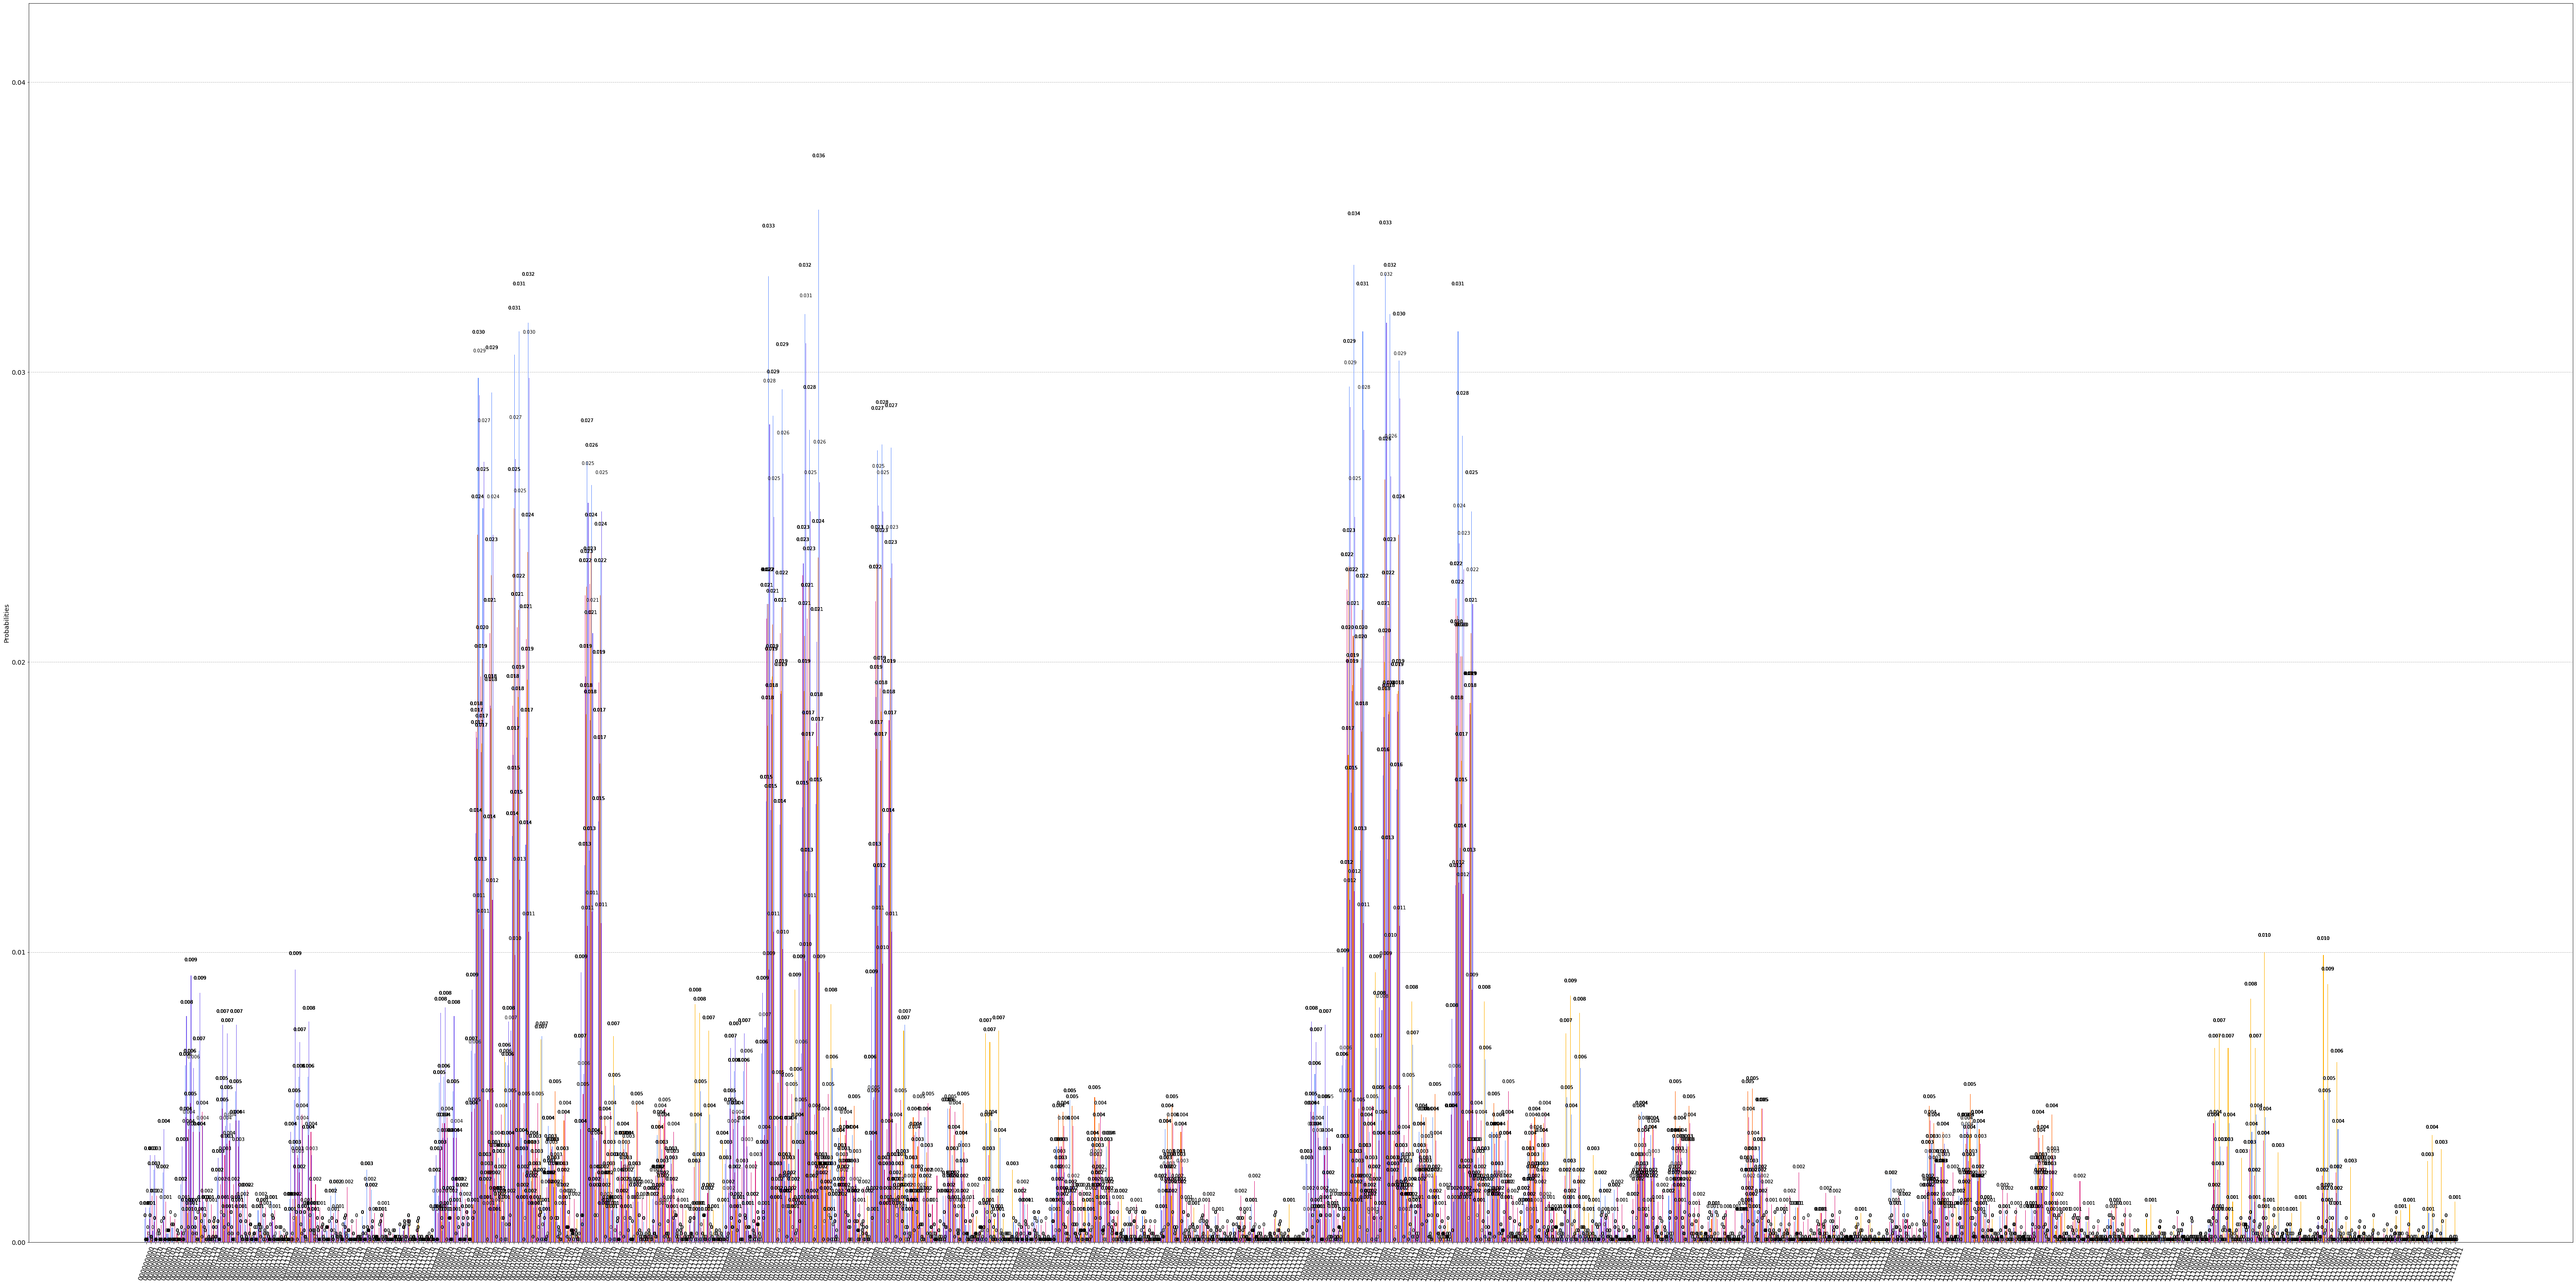

In [23]:
plot_histogram([counts[k] for k in range(8)], figsize = (100,50))

In [424]:
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
         if val == value: 
             return key 
  
    return "key doesn't exist"

In [681]:
#Group degenerate states

ordered_by_cost = []
for k in range(8):
    ordered = {}
    for state in counts[k]:
        cost_eval = np.round(eval_cost(state, qubo), 8)
        if cost_eval in ordered.values():
            key = get_key(cost_eval, ordered)
            new_key = str(key) + ', ' + str(state)
            ordered[new_key] = ordered.pop(key)
        else:
            ordered[state] = cost_eval
        
    some_counts = []
    for state in ordered:
        split = state.split(", ")
        some_counts.append((state, ordered[state], sum([counts[k][u] for u in split])/10000))    
    some_counts = sorted(some_counts, key = lambda x: x[1])
    ordered_by_cost.append(some_counts)

In [682]:
ordered_by_cost[3]

[('010010001, 100010001', 0.21052632, 0.0378),
 ('010001001, 100001001, 100001100', 0.22807018, 0.0541),
 ('001010010, 010010010, 100010010, 100010100', 0.24561404, 0.077),
 ('001001010, 001001100, 001100001, 001100100, 010001010, 010001100, 010100001, 100001010, 100100001',
  0.26315789,
  0.1591),
 ('001010001, 001010100, 010010100', 0.28070175, 0.0555),
 ('001001001, 100100100', 0.29824561, 0.0351),
 ('010100100', 0.33333333, 0.0181),
 ('001100010', 0.36842105, 0.0187),
 ('010100010, 100100010', 0.43859649, 0.0353),
 ('001001000, 001100000, 010001000, 100001000', 1.80701754, 0.0025),
 ('001010000, 010000001, 010010000, 100000001, 100010000', 1.8245614, 0.0027),
 ('000010001, 000010010', 1.84210526, 0.002),
 ('000001001, 000001010, 000001100, 000100001, 001000001, 001000010, 001000100, 100000100',
  1.85964912,
  0.0065),
 ('000010100, 010100000, 100100000', 1.87719298, 0.0023),
 ('000100100, 010000010, 010000100, 100000010', 1.89473684, 0.0044),
 ('000100010', 2.0, 0.0005),
 ('11001

In [683]:
energy_counts = []
for v in range(8):
    new_dict = { (ordered_by_cost[v][u][1], ordered_by_cost[v][u][0]) : ordered_by_cost[v][u][2] for u in range(len(ordered_by_cost[v]))  if ordered_by_cost[v][u][1] <= 4.5}
    #new_dict[(900, 'rest')] = sum([ordered_by_cost[v][u][2]  for u in range(len(ordered_by_cost[v]))  if ordered_by_cost[v][u][1] > 0.5 ] )
    energy_counts.append(new_dict)

In [684]:
energy_counts[0]

{(0.21052632, '010010001, 100010001'): 0.0292,
 (0.22807018, '010001001, 100001001, 100001100'): 0.0398,
 (0.24561404, '001010010, 010010010, 100010010, 100010100'): 0.0577,
 (0.26315789,
  '001001010, 001001100, 001100001, 001100100, 010001010, 010001100, 010100001, 100001010, 100100001'): 0.1183,
 (0.28070175, '001010001, 001010100, 010010100'): 0.0408,
 (0.29824561, '001001001, 100100100'): 0.0263,
 (0.33333333, '010100100'): 0.015,
 (0.36842105, '001100010'): 0.015,
 (0.43859649, '010100010, 100100010'): 0.0275,
 (1.80701754, '001001000, 001100000, 010001000, 100001000'): 0.0241,
 (1.8245614, '001010000, 010000001, 010010000, 100000001, 100010000'): 0.0297,
 (1.84210526, '000010001, 000010010'): 0.0113,
 (1.85964912,
  '000001001, 000001010, 000001100, 000100001, 001000001, 001000010, 001000100, 100000100'): 0.0461,
 (1.87719298, '000010100, 010100000, 100100000'): 0.0169,
 (1.89473684, '000100100, 010000010, 010000100, 100000010'): 0.0233,
 (2.0, '000100010'): 0.0038,
 (2.01754386

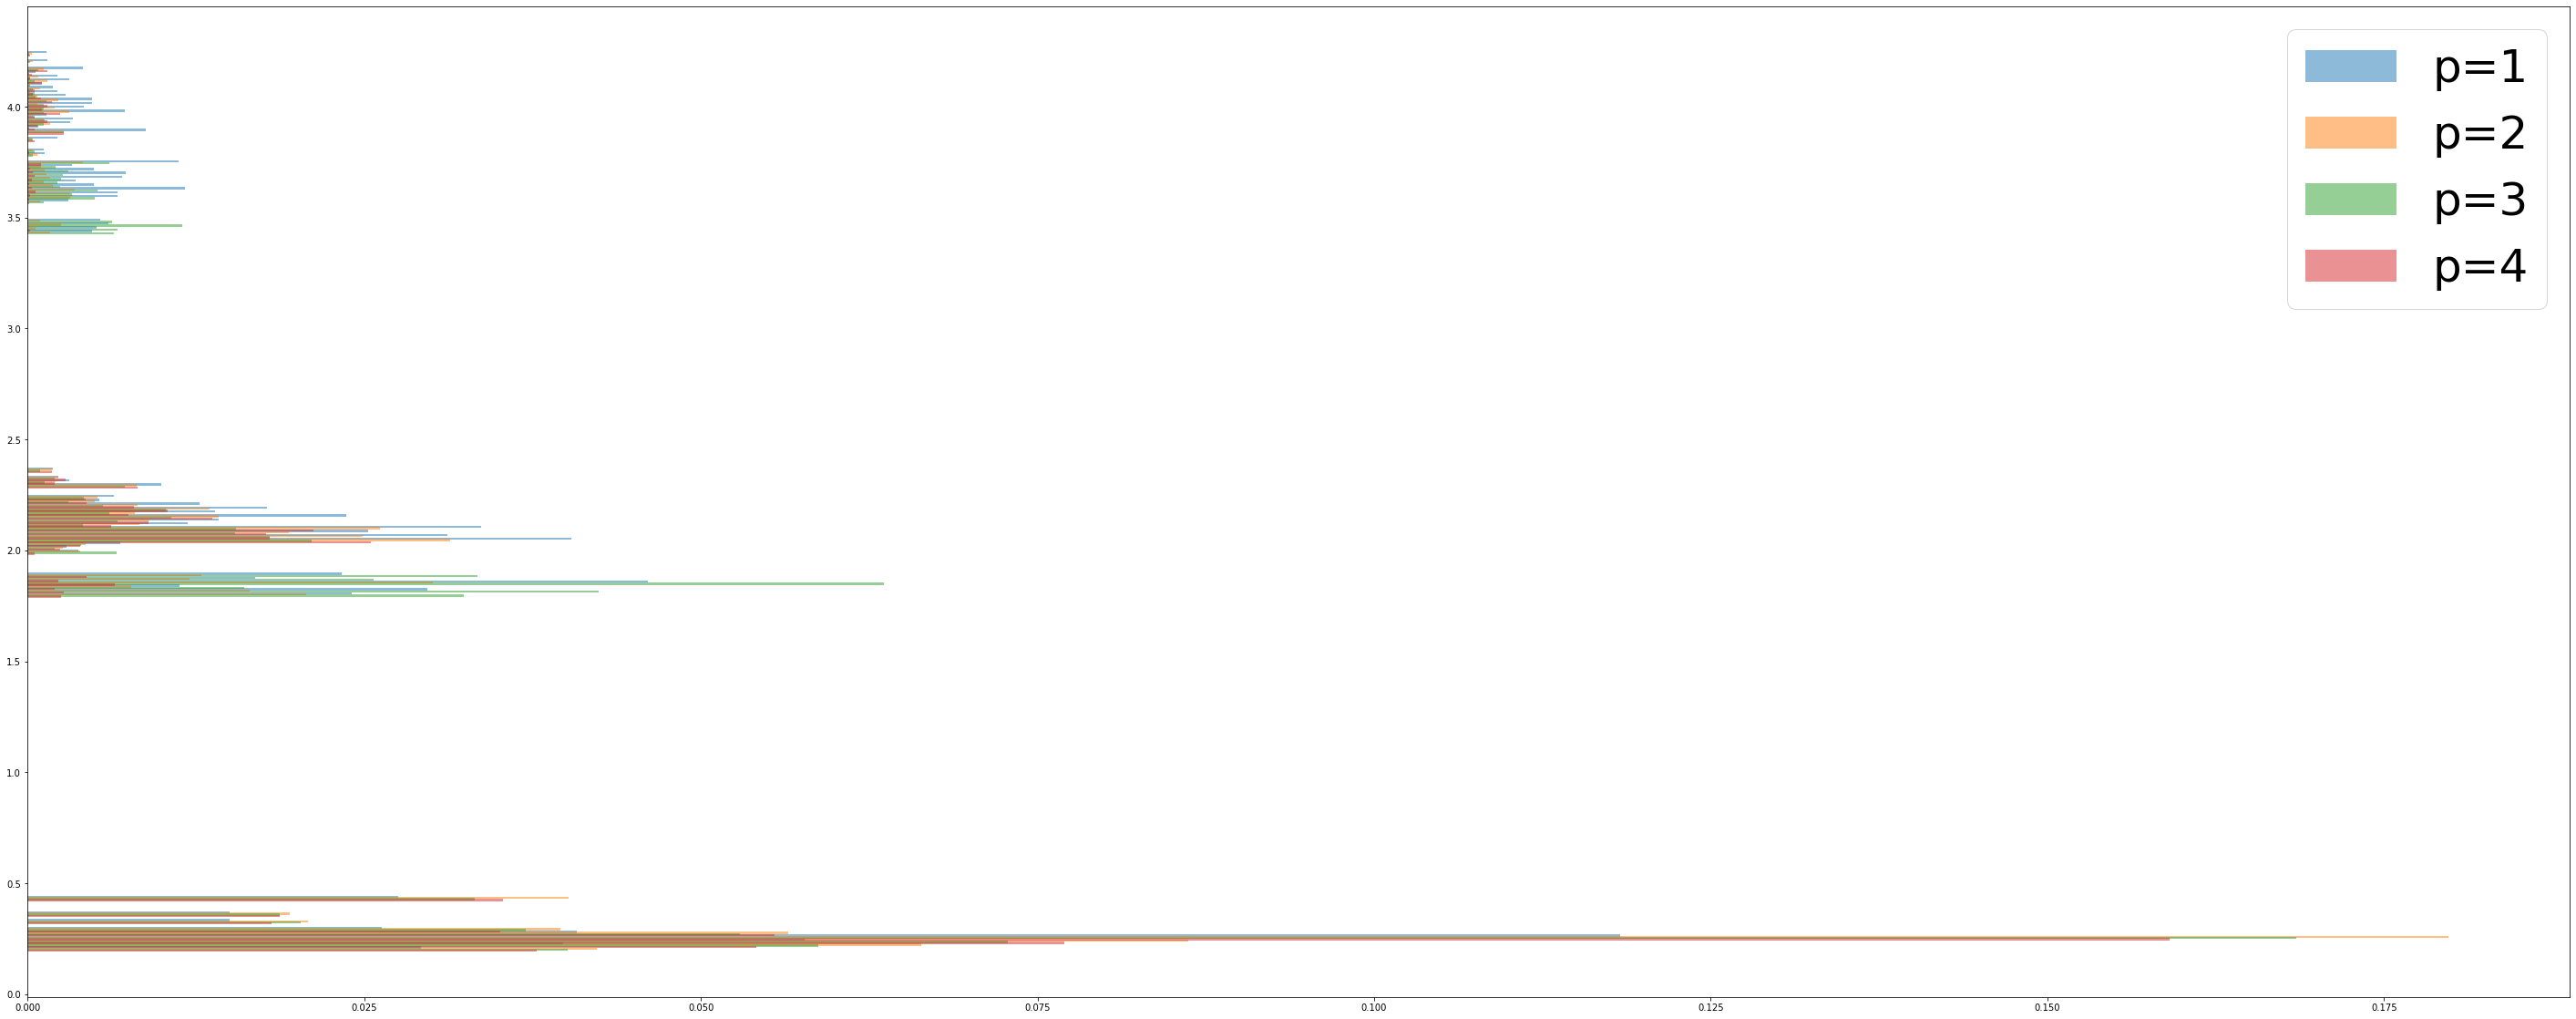

In [689]:
plt.figure(figsize = (50,20))
width = 0.01
for v in range(0,4):
    y = np.array( [list(energy_counts[v].keys())[u][0] for u in range(len(energy_counts[v].keys()))] )
    plt.barh(y = y -0.005*v , width = energy_counts[v].values(), alpha = 0.5, height=width)
plt.legend(['p='+str(u+1) for u in range(0,4)], loc = 'upper right', fontsize = 50)
plt.show()

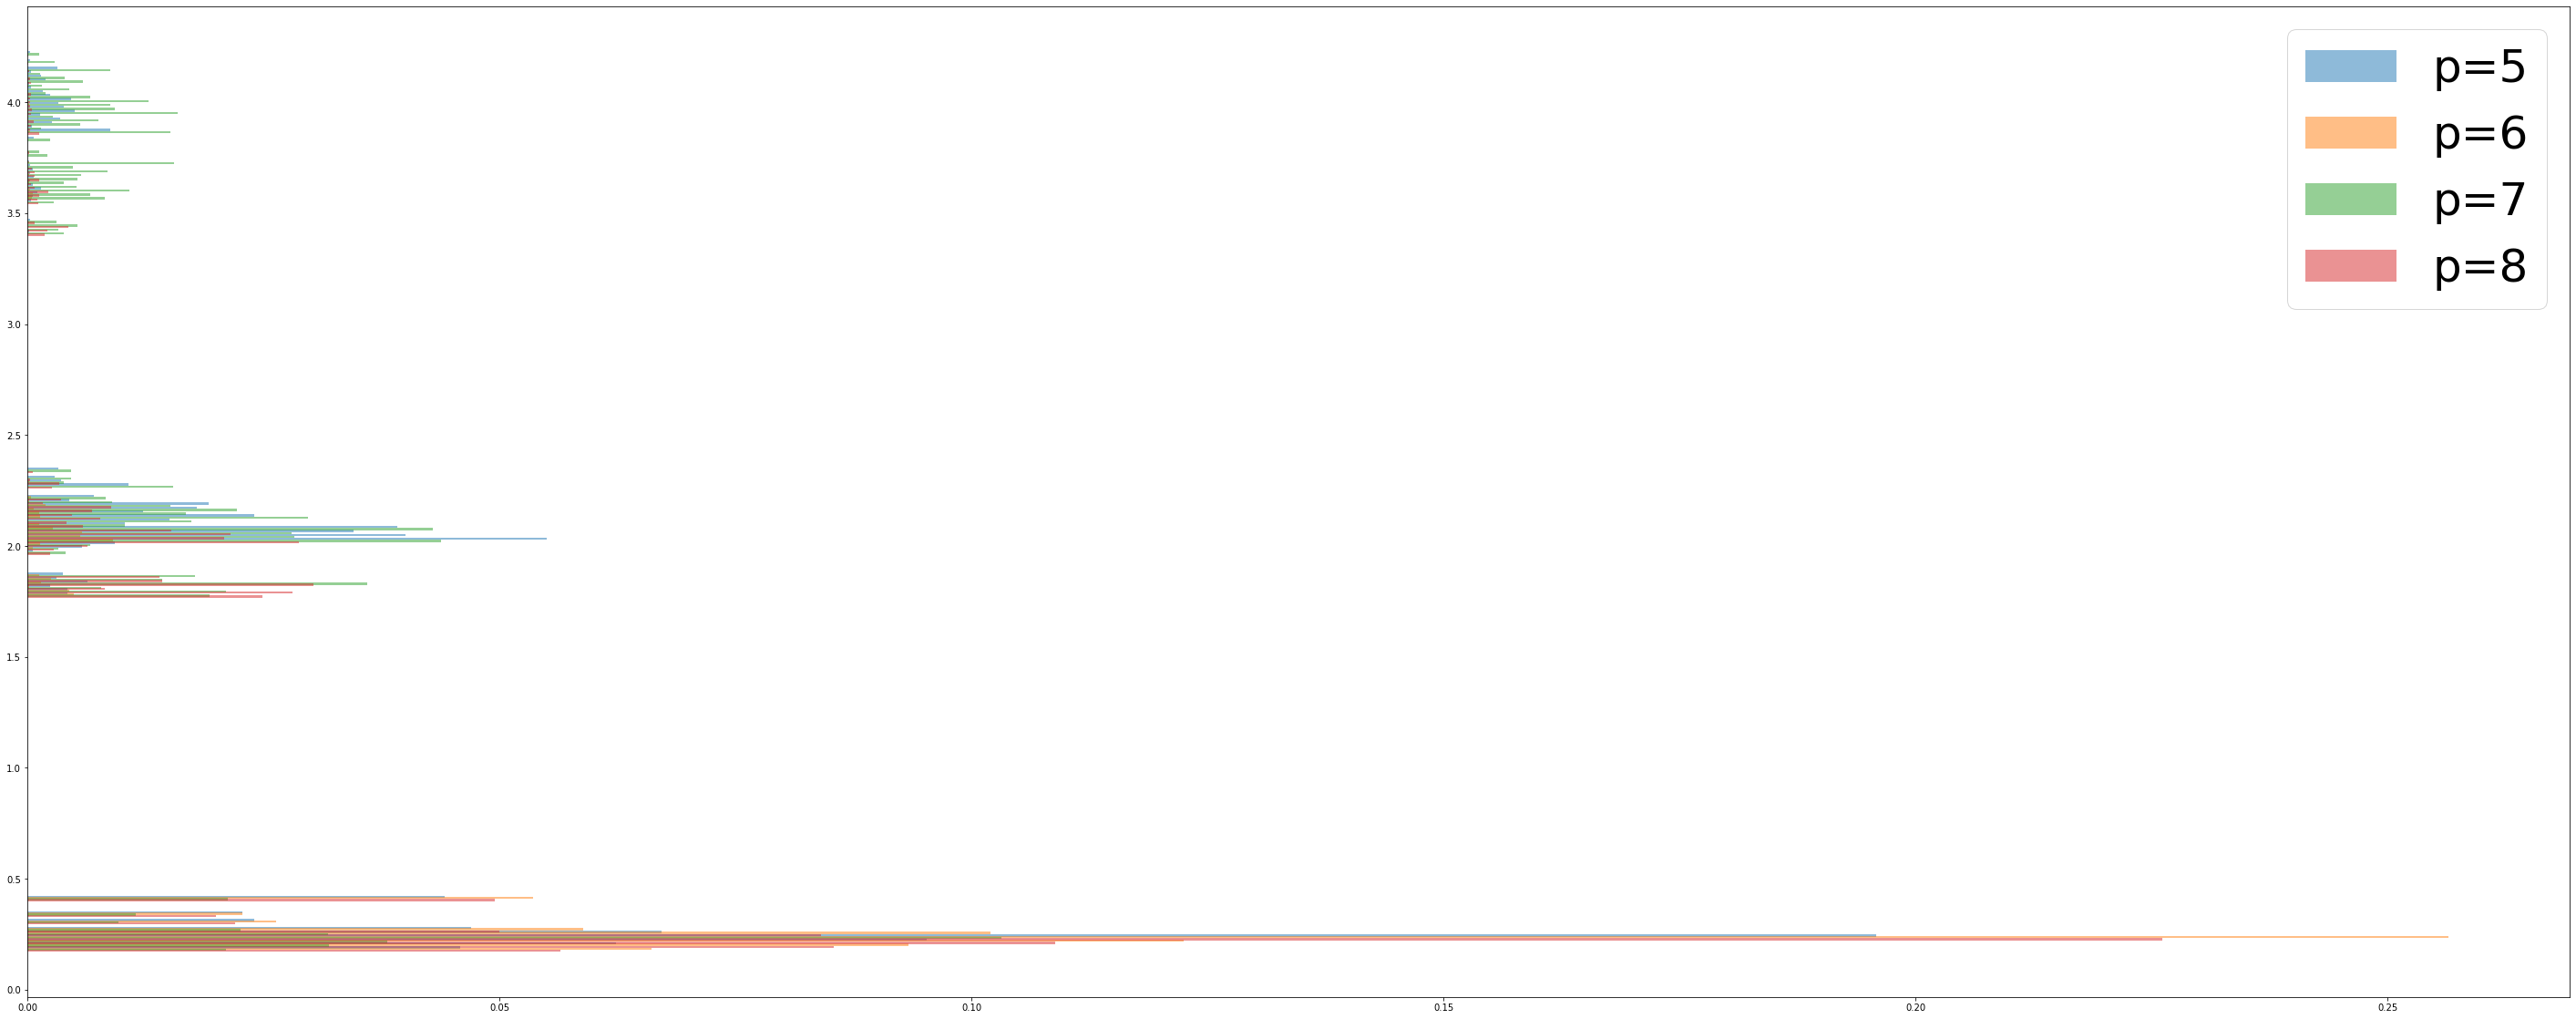

In [690]:
plt.figure(figsize = (50,20))
width = 0.01
for v in range(4,8):
    y = np.array( [list(energy_counts[v].keys())[u][0] for u in range(len(energy_counts[v].keys()))] )
    plt.barh(y = y -0.005*v , width = energy_counts[v].values(), alpha = 0.5, height=width)
plt.legend(['p='+str(u+1) for u in range(4,8)], loc = 'upper right', fontsize = 50)
plt.show()

In [691]:
x = np.arange(1,7, 1)

In [692]:
y = np.array( [list(energy_counts[u].values())[0] for u in range(6)] )

In [693]:
y

array([0.0292, 0.0423, 0.0401, 0.0378, 0.0458, 0.0661])

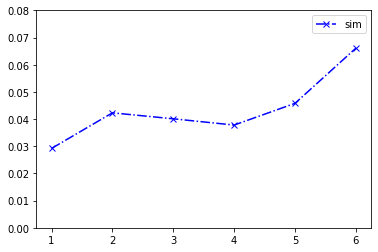

In [694]:
plt.figure()
plt.ylim([0,0.08])
plt.plot(x, y, 'bx', linestyle = '-.')
plt.legend(['sim', 'noise'])
plt.show()

In [589]:
from qiskit.providers.aer.noise import NoiseModel

In [590]:
from qiskit.test.mock import FakeToronto

In [650]:
device_backend = FakeToronto()
noise_model = NoiseModel.from_backend(device_backend)
no_shots = 10000
params = []
counts = []
for k in range(1,9):
    params = np.append( params, optimal_pairs[k-1])
    qaoa = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
    circuit = qaoa.construct_circuit( params )[0]
    circuit.measure_all(inplace = True)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator, shots=no_shots, noise_model = noise_model ).result()
    count = result.get_counts(circuit)
    counts.append(count)

In [661]:
ordered_by_cost = []
for k in range(8):
    ordered = {}
    for state in counts[k]:
        cost_eval = np.round(eval_cost(state, qubo), 8)
        if cost_eval in ordered.values():
            key = get_key(cost_eval, ordered)
            new_key = str(key) + ', ' + str(state)
            ordered[new_key] = ordered.pop(key)
        else:
            ordered[state] = cost_eval
        
    some_counts = []
    for state in ordered:
        split = state.split(", ")
        some_counts.append((state, ordered[state], sum([counts[k][u] for u in split])/10000))    
    some_counts = sorted(some_counts, key = lambda x: x[1])
    ordered_by_cost.append(some_counts)
energy_counts = []
for v in range(8):
    new_dict = { (ordered_by_cost[v][u][1], ordered_by_cost[v][u][0]) : ordered_by_cost[v][u][2] for u in range(len(ordered_by_cost[v]))  if ordered_by_cost[v][u][1] <= .5}
    #new_dict[(900, 'rest')] = sum([ordered_by_cost[v][u][2]  for u in range(len(ordered_by_cost[v]))  if ordered_by_cost[v][u][1] > 0.5 ] )
    energy_counts.append(new_dict)

In [672]:
x1 = np.arange(1,7, 1)
y1 = np.array( [list(energy_counts[u].values())[0] for u in range(6)] )

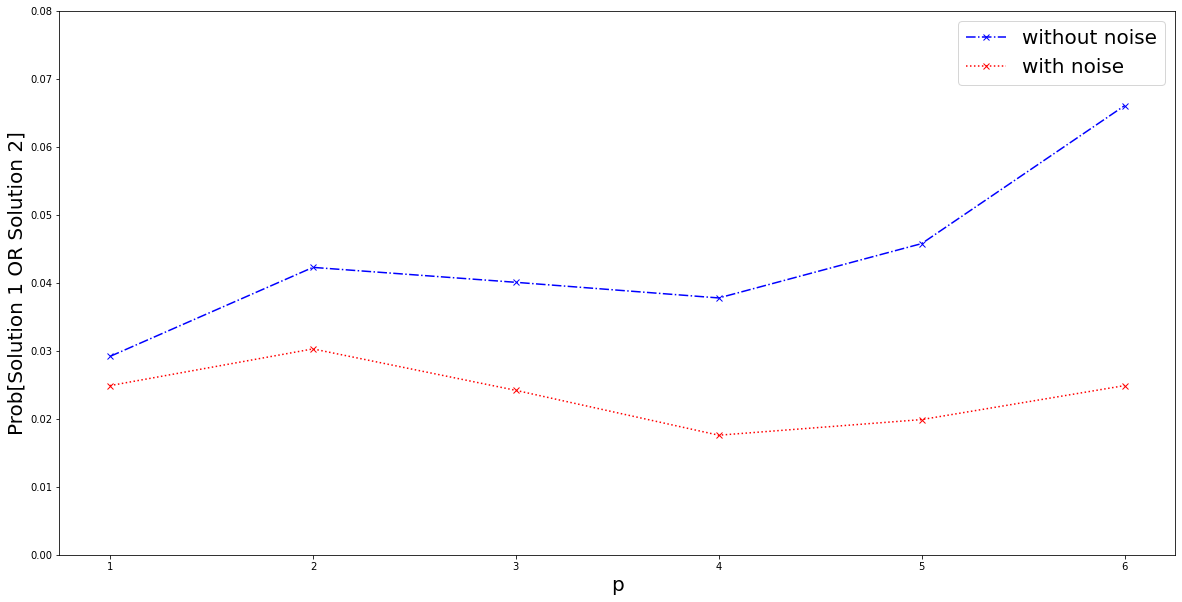

In [699]:
plt.figure(figsize = (20,10))
plt.ylim([0,0.08])
plt.plot(x, y, 'bx', linestyle = '-.')
plt.plot(x1, y1, 'rx', linestyle = 'dotted')
plt.xlabel('p', fontsize = 20)
plt.ylabel('Prob[Solution 1 OR Solution 2]', fontsize = 20)
plt.legend(['without noise', 'with noise'], fontsize = 20)
plt.show()

In [701]:
from qiskit.providers.ibmq import IBMQFactory

In [709]:
account = IBMQFactory()
account.load_account()
account.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>]

In [ ]:
provider = account.get_provider(hub='ibm-q-melbourne', group='uom-researchers', project='default')

In [712]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_rochester') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBackend('ibmq_cambridge') from IBMQ(hub='ibm-q-melbourne', group='uom-researchers', project='default')>,
 <IBMQBack

In [721]:
backend = provider.get_backend('ibmq_manhattan')

In [ ]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel

In [722]:
noise_model = NoiseModel.from_backend(backend)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067867 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067812 > 1.066667). Truncating to maximum value.


In [723]:
no_shots = 10000
params = []
counts = []
for k in range(1,9):
    params = np.append( params, optimal_pairs[k-1])
    qaoa = QAOA(operator = op, p=k, quantum_instance=BasicAer.get_backend('statevector_simulator'))
    circuit = qaoa.construct_circuit( params )[0]
    circuit.measure_all(inplace = True)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator, shots=no_shots, noise_model = noise_model ).result()
    count = result.get_counts(circuit)
    counts.append(count)

In [724]:
ordered_by_cost = []
for k in range(8):
    ordered = {}
    for state in counts[k]:
        cost_eval = np.round(eval_cost(state, qubo), 8)
        if cost_eval in ordered.values():
            key = get_key(cost_eval, ordered)
            new_key = str(key) + ', ' + str(state)
            ordered[new_key] = ordered.pop(key)
        else:
            ordered[state] = cost_eval
        
    some_counts = []
    for state in ordered:
        split = state.split(", ")
        some_counts.append((state, ordered[state], sum([counts[k][u] for u in split])/10000))    
    some_counts = sorted(some_counts, key = lambda x: x[1])
    ordered_by_cost.append(some_counts)
energy_counts = []
for v in range(8):
    new_dict = { (ordered_by_cost[v][u][1], ordered_by_cost[v][u][0]) : ordered_by_cost[v][u][2] for u in range(len(ordered_by_cost[v]))  if ordered_by_cost[v][u][1] <= .5}
    #new_dict[(900, 'rest')] = sum([ordered_by_cost[v][u][2]  for u in range(len(ordered_by_cost[v]))  if ordered_by_cost[v][u][1] > 0.5 ] )
    energy_counts.append(new_dict)

In [725]:
x2 = np.arange(1,7, 1)
y2 = np.array( [list(energy_counts[u].values())[0] for u in range(6)] )

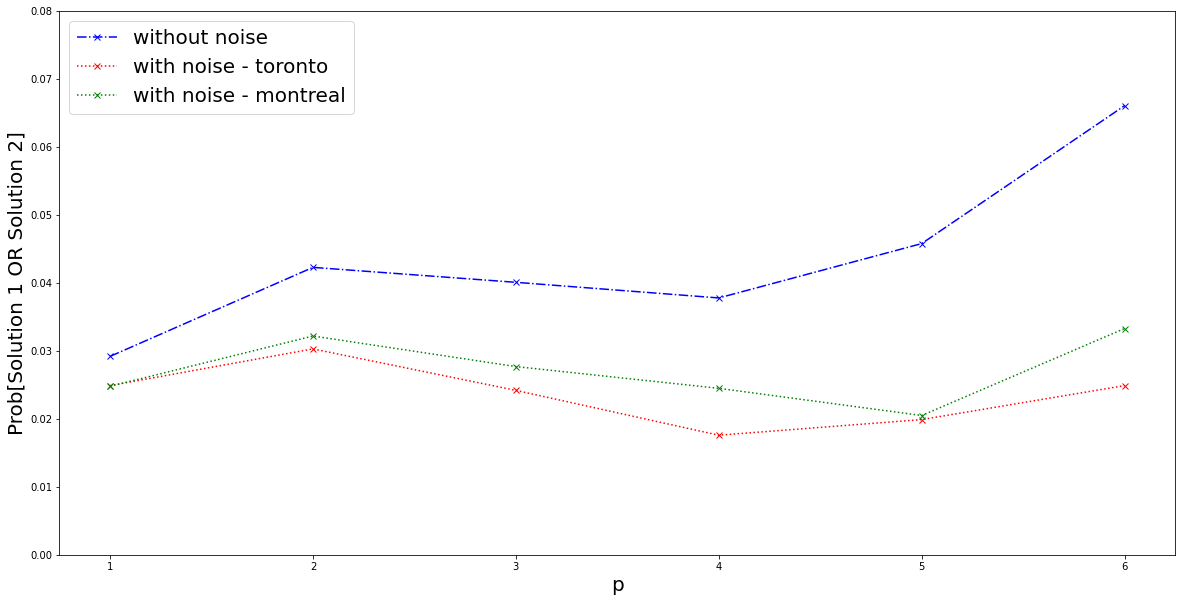

In [726]:
plt.figure(figsize = (20,10))
plt.ylim([0,0.08])
plt.plot(x, y, 'bx', linestyle = '-.')
plt.plot(x1, y1, 'rx', linestyle = 'dotted')
plt.plot(x2, y2, 'gx', linestyle = 'dotted')
plt.xlabel('p', fontsize = 20)
plt.ylabel('Prob[Solution 1 OR Solution 2]', fontsize = 20)
plt.legend(['without noise', 'with noise - toronto', 'with noise - montreal'], fontsize = 20)
plt.show()